# MOA prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../common_.py
import sys
sys.path.append("../..")
from common import *

In [3]:
import pickle

import pyarrow
from sklearn.decomposition import FactorAnalysis
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

# Data

In [4]:
try:
    paths = snakemake.input.paths
    labels_path = snakemake.input.labels
except NameError:
    data_root = Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/BBBC021")
    data_dir = data_root / "results" / "images_subset_v3"
    path = data_dir / "features.parquet"
    labels_path = data_dir.parent / "labels.parquet"
    moa_path = data_root / "BBBC021_v1_moa.csv"
    image_path = data_root / "BBBC021_v1_image.csv"

In [5]:
moa = pandas.read_csv(moa_path)
image = pandas.read_csv(image_path)

In [6]:
moa_image = moa.merge(
    image,
    left_on=["compound", "concentration"],
    right_on=["Image_Metadata_Compound", "Image_Metadata_Concentration"]
).drop(columns=["Image_Metadata_Compound", "Image_Metadata_Concentration"])

In [7]:
moa_image["batch"] = moa_image["Image_Metadata_Plate_DAPI"].apply(lambda p: int(p.split("_")[0][len("Week"):])).astype('category')

<AxesSubplot:xlabel='batch', ylabel='moa'>

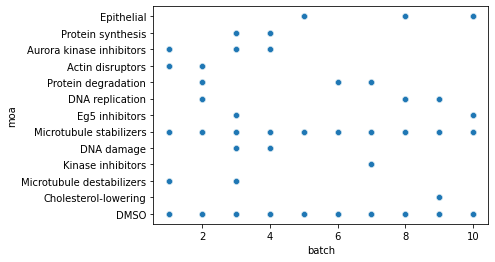

In [8]:
seaborn.scatterplot(data=moa_image, x="batch", y="moa")

To apply the Not-same-compound-or-batch approach by [Ando et al.](https://www.biorxiv.org/content/10.1101/161422v1.full.pdf), the Cholesterol-lowering and Kinase Inhibitors MOAs should be removed from the datasets as they are only present on one batch.

In [9]:
moa_image = moa_image[~moa_image["moa"].isin(["Cholesterol-lowering", "Kinase inhibitors"])]

<AxesSubplot:xlabel='batch', ylabel='compound'>

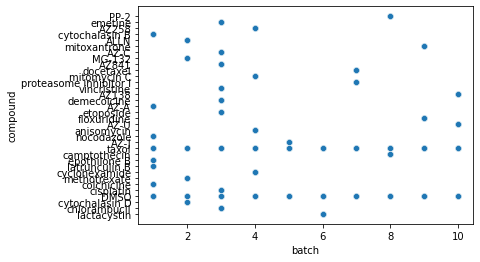

In [10]:
seaborn.scatterplot(data=moa_image, x="batch", y="compound")

In [11]:
treatments = moa_image[~moa_image["compound"].isin(["DMSO"])]

According to the previously mentioned research 92 treatments should remain.

In [12]:
(treatments["compound"] + treatments["concentration"].astype(str)).unique().shape

(92,)

In [13]:
%%time
df = pq.read_table(path).to_pandas()

CPU times: user 3.26 s, sys: 1.66 s, total: 4.92 s
Wall time: 10.8 s


In [14]:
df.columns[df.isna().all()]

Index([], dtype='object')

In [15]:
df.shape

(512635, 677)

In [16]:
moa_image.columns = ["meta_" + c for c in moa_image.columns]

In [17]:
df = df.merge(moa_image, left_on="meta_filename", right_on="meta_Image_FileName_DAPI")

# Removing interplate variation

In [18]:
qq_dmso = df[df["meta_moa"] == "DMSO"].groupby("meta_Image_Metadata_Plate_DAPI")[df.filter(regex="feat").columns].quantile((0.01, 0.99))

In [19]:
dfs = []
for idx, gdf in df.groupby("meta_Image_Metadata_Plate_DAPI"):
    print(idx)
    df_scaled = (gdf.filter(regex="feat") - qq_dmso.loc[idx, 0.01]) / (qq_dmso.loc[idx, 0.99] - qq_dmso.loc[idx, 0.01])
    df_scaled = pandas.concat([df_scaled, gdf.filter(regex="meta")], axis=1)
    
    dfs.append(df_scaled)

Week10_40111
Week10_40115
Week10_40119
Week1_22123
Week1_22141
Week1_22161
Week1_22361
Week1_22381
Week1_22401
Week2_24121
Week2_24141
Week2_24161
Week2_24361
Week2_24381
Week2_24401
Week3_25421
Week3_25441
Week3_25461
Week3_25681
Week3_25701
Week3_25721
Week4_27481
Week4_27521
Week4_27542
Week4_27801
Week4_27821
Week4_27861
Week5_28901
Week5_28921
Week5_28961
Week5_29301
Week5_29321
Week5_29341
Week6_31641
Week6_31661
Week6_31681
Week6_32061
Week6_32121
Week6_32161
Week7_34341
Week7_34381
Week7_34641
Week7_34661
Week7_34681
Week8_38203
Week8_38221
Week8_38241
Week8_38341
Week8_38342
Week9_39206
Week9_39221
Week9_39222
Week9_39282
Week9_39283
Week9_39301


In [20]:
df = pandas.concat(dfs)
del dfs

In [21]:
allnan = df.columns[df.isna().all()]
allnan

Index(['feat_euler_number_combined', 'feat_euler_number_actin'], dtype='object')

In [22]:
df = df.drop(columns=allnan)

In [23]:
nancols = df.columns[df.isna().any()]
nancols

Index(['feat_perimeter_crofton_DAPI', 'feat_solidity_DAPI', 'feat_extent_DAPI',
       'feat_inertia_tensor-0-0_DAPI', 'feat_inertia_tensor-0-1_DAPI',
       'feat_inertia_tensor-1-0_DAPI', 'feat_inertia_tensor-1-1_DAPI',
       'feat_inertia_tensor_eigvals-0_DAPI',
       'feat_inertia_tensor_eigvals-1_DAPI', 'feat_moments-0-0_DAPI',
       ...
       'feat_glcm_std_ASM_3_tubulin', 'feat_glcm_std_ASM_5_tubulin',
       'feat_sobel_mean_tubulin', 'feat_sobel_std_tubulin',
       'feat_sobel_max_tubulin', 'feat_sobel_min_tubulin',
       'feat_combined_sobel_mean_tubulin', 'feat_combined_sobel_std_tubulin',
       'feat_combined_sobel_max_tubulin', 'feat_combined_sobel_min_tubulin'],
      dtype='object', length=168)

# Exploration

In [275]:
df = df[~df.isna().any(axis=1)]

In [276]:
mu = (
    df[df["meta_moa"] != "DMSO"]
    .groupby(["meta_compound", "meta_concentration", "meta_Replicate"])
    .agg({c: 'mean' for c in df.filter(regex="feat").columns} | {c: lambda x: numpy.unique(x)[0] for c in df.filter(regex="meta")})
).reset_index(drop=True)

mu = mu.groupby(["meta_compound", "meta_concentration"]).agg({c: 'median' for c in mu.filter(regex="feat").columns} | {c: lambda x: numpy.unique(x)[0] for c in mu.filter(regex="meta")})

In [277]:
mu.shape

(92, 690)

In [278]:
treatment_profiles = mu.reset_index(drop=True)

In [279]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [280]:
dimred = PCA().fit_transform(scale(treatment_profiles.filter(regex="feat")))

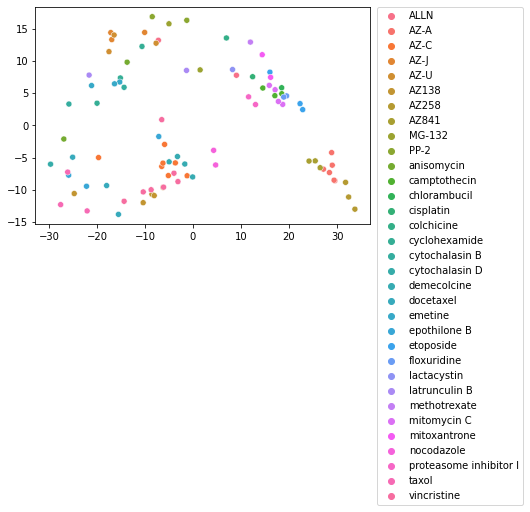

In [281]:
seaborn.scatterplot(x=dimred[:, 0], y=dimred[:, 1], hue=treatment_profiles["meta_compound"])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

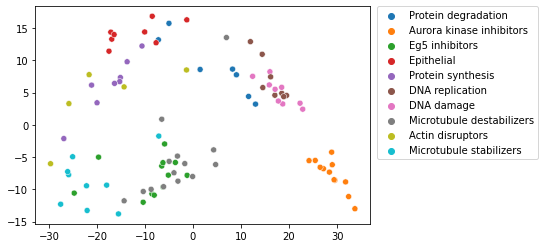

In [282]:
seaborn.scatterplot(x=dimred[:, 0], y=dimred[:, 1], hue=treatment_profiles["meta_moa"])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [283]:
from umap import UMAP

In [284]:
dimred = UMAP(metric="cosine", min_dist=0.5, n_neighbors=8, random_state=0).fit_transform(scale(treatment_profiles.filter(regex="feat")))

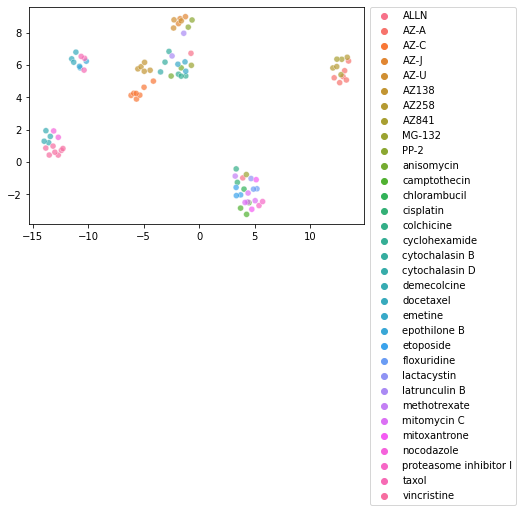

In [285]:
seaborn.scatterplot(x=dimred[:, 0], y=dimred[:, 1], hue=treatment_profiles["meta_compound"], edgecolors="none", alpha=.7)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

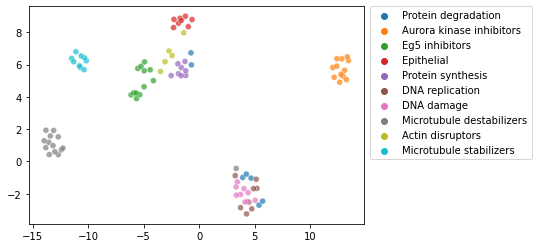

In [286]:
seaborn.scatterplot(x=dimred[:, 0], y=dimred[:, 1], hue=treatment_profiles["meta_moa"], edgecolors="none", alpha=.7)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Classification

In [24]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

In [30]:
true = []
preds = []

for idx, df_test in tqdm(df[df["meta_moa"] != "DMSO"].groupby("meta_compound")):
    test_compounds = df[df["meta_batch"].isin(gdf["meta_batch"].unique())]["meta_compound"].unique()
    test_index = df["meta_compound"].isin(test_compounds)
    
    df_train = df[~test_index]
    
    e1 = StandardScaler()
    e1.fit(df_train.filter(regex="feat"))
    
    df_train_t = pandas.concat([
        pandas.DataFrame(e1.transform(df_train.filter(regex="feat")), columns=df_train.filter(regex="feat").columns, index=df_train.index),
        df_train.filter(regex="meta")
    ], axis=1)
    df_test_t = pandas.concat([
        pandas.DataFrame(e1.transform(df_test.filter(regex="feat")), columns=df_test.filter(regex="feat").columns, index=df_test.index),
        df_test.filter(regex="meta")
    ], axis=1)
    
    treatment_profiles_train = (
        df_train_t
        .groupby(["meta_compound", "meta_concentration", "meta_Replicate"])
        .agg({c: 'mean' for c in df_train_t.filter(regex="feat").columns} | {c: lambda x: numpy.unique(x)[0] for c in df_train_t.filter(regex="meta")})
        .reset_index(drop=True)
        .groupby(["meta_compound", "meta_concentration"])
        .agg({c: 'median' for c in df_train_t.filter(regex="feat").columns} | {c: lambda x: numpy.unique(x)[0] for c in df_train_t.filter(regex="meta")})
        .reset_index(drop=True)
    )
    
    treatment_profiles_test = (
        df_test_t
        .groupby(["meta_compound", "meta_concentration", "meta_Replicate"])
        .agg({c: 'mean' for c in df_test_t.filter(regex="feat").columns} | {c: lambda x: numpy.unique(x)[0] for c in df_test_t.filter(regex="meta")})
        .reset_index(drop=True)
        .groupby(["meta_compound", "meta_concentration"])
        .agg({c: 'median' for c in df_test_t.filter(regex="feat").columns} | {c: lambda x: numpy.unique(x)[0] for c in df_test_t.filter(regex="meta")})
        .reset_index(drop=True)
    )
    
    e2 = KNeighborsClassifier(n_neighbors=1, metric="cosine")
    e2.fit(
        X=treatment_profiles_train.filter(regex="feat"),
        y=treatment_profiles_train["meta_moa"]
    )
    
    true.extend(treatment_profiles_test["meta_moa"])
    preds.extend(e2.predict(treatment_profiles_test.filter(regex="feat")))

  0%|          | 0/33 [00:00<?, ?it/s]

In [31]:
accuracy_score(true, preds)

0.9891304347826086

In [32]:
len(true), len(preds)

(92, 92)

Text(11, 10, 'Overall Acc.:99%')

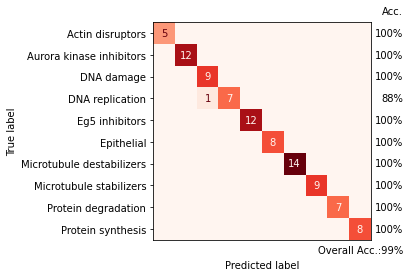

In [28]:
fig, ax = plt.subplots()
cm = confusion_matrix(true, preds)
ConfusionMatrixDisplay(cm, display_labels=sorted(treatments["moa"].unique())).plot(ax=ax, colorbar=False, cmap="Reds")

for child in ax.get_children():
    if isinstance(child, matplotlib.text.Text) and child._text == '0':
        child.set_visible(False)

ax.set_xticks([])
ax.xaxis.labelpad = 20

acc = (numpy.diag(cm)*100 / cm.sum(axis=1))
for i in range(len(cm)):
    ax.text(x=11, y=i, s='%.0f%%' % acc[i], va="center", ha="right")
ax.text(x=11, y=-1, s='Acc.', va="center", ha="right")
ax.text(x=11, y=10, s='Overall Acc.:%.0f%%' % numpy.mean(acc), va="center", ha="right")

# plt.savefig(data_dir / "figures" / "bbbc_confmat_scip.png", dpi=300, bbox_inches="tight")